In [1]:
cd /Users/hjsong/Playground/Tutorials/PyTorchZeroToAll/

/Users/hjsong/Playground/Tutorials/PyTorchZeroToAll


In [2]:
!ll ./data/

/bin/sh: ll: command not found


In [3]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
            
import pdb 


In [4]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'numpy',
 'pandas',
 'torch',
 'torch.nn',
 'torch.nn.functional',
 'matplotlib.pyplot',
 'types',
 'pdb']

In [5]:
# Globals
RSEED = 11

## Data load

In [6]:
x_data = torch.Tensor([[1,2,3,4]]).view(4,1)
y_data = torch.Tensor([0,0,1,1]).view(4,1)

In [7]:
print(x_data, '\n', y_data)

tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.]]) 
 tensor([[ 0.],
        [ 0.],
        [ 1.],
        [ 1.]])


Load diabetes dataset

In [8]:
xy = np.loadtxt('./data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
print(xy.shape); print(xy)

(759, 9)
[[-0.294118   0.487437   0.180328  ... -0.53117   -0.0333333  0.       ]
 [-0.882353  -0.145729   0.0819672 ... -0.766866  -0.666667   1.       ]
 [-0.0588235  0.839196   0.0491803 ... -0.492741  -0.633333   0.       ]
 ...
 [-0.411765   0.21608    0.180328  ... -0.857387  -0.7        1.       ]
 [-0.882353   0.266332  -0.0163934 ... -0.768574  -0.133333   0.       ]
 [-0.882353  -0.0653266  0.147541  ... -0.797609  -0.933333   1.       ]]


In [9]:
X = xy[:,:-1]; print(X.shape)
y = xy[:,-1]; print(y.shape)

X = torch.from_numpy(X) #share the same memory 
y = torch.from_numpy(y)

(759, 8)
(759,)


Train and test set


### Custom data loader

In [11]:
from torch.utils.data import Dataset, DataLoader
class DiabetesDataset(Dataset):
    def __init__(self, ids):
        # Ideally we wouldn't load all data here.
        # Rather, read each file when __getitem__ is called
        xy = np.loadtxt('./data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
        self.x_data = xy[:,:-1]
        self.y_data = xy[:, -1]
        
        self.ids = ids
        self.len = len(ids)

        
    def __getitem__(self, idx):
        "Returns a sample in the format of [x_data[idx], y_data[idx]]"
#         print("idx: ", idx)
        ID = self.ids[idx]
        return self.x_data[ID,:], self.y_data[ID]
    
    def __len__(self):
        return self.len
    

In [12]:
from sklearn.model_selection import train_test_split
labels = y.numpy()
train_ids, test_ids = train_test_split(range(len(labels)),
                                        stratify=labels,
                                        test_size=0.33, 
                                        random_state=RSEED) #stratified 
# train_ids, dev_ids = train_test_split(tr_dev_ids, test_size=0.5, random_state=RSEED)

In [13]:
partition = {'train': train_ids, 
#              'dev': dev_ids, 
             'test': test_ids}
train_dataset = DiabetesDataset(partition['train'])
# dev_dataset = DiabetesDataset(partition['dev'])
test_dataset = DiabetesDataset(partition['test'])

In [14]:
#2. new dataloader instance
data_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':1}
train_loader = DataLoader(dataset=train_dataset, **data_params)
# dev_loader = DataLoader(dataset=dev_dataset, **data_params)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Need to understand test_loader's loading order

In [15]:
dataiter = iter(test_loader)
x,y = dataiter.next()
print(x)
print("label: ",y)

tensor([[-0.7647,  0.0653,  0.0492, -0.2929, -0.7187, -0.0909,  0.1289,
         -0.5667],
        [ 0.0000, -0.0653,  0.6393, -0.2121, -0.8298,  0.2936, -0.1947,
         -0.5333],
        [ 0.5294,  0.0653,  0.1475,  0.0000,  0.0000,  0.0194, -0.8523,
          0.0333],
        [-0.5294,  0.7387,  0.1475, -0.7172, -0.6028, -0.1148, -0.7583,
         -0.6000],
        [-0.5294,  0.4874, -0.0164, -0.4545, -0.2482, -0.0790, -0.9385,
         -0.7333],
        [-0.4118,  0.2261,  0.4098,  0.0000,  0.0000,  0.0343, -0.8190,
         -0.6000],
        [-0.8824,  0.2261,  0.4754,  0.0303, -0.4799,  0.4814, -0.7891,
         -0.6667],
        [-0.5294,  0.3266,  0.0000,  0.0000,  0.0000, -0.0194, -0.8087,
         -0.9333],
        [ 0.0588,  0.4573,  0.3115, -0.0707, -0.6927,  0.1297, -0.5226,
         -0.3667],
        [-0.4118, -0.1457,  0.2131, -0.5556,  0.0000, -0.1356, -0.0213,
         -0.6333],
        [-0.1765,  0.8492,  0.3770, -0.3333,  0.0000,  0.0581, -0.7635,
         -0.3333],

## Binary classifer model

In [16]:
class BCModel(nn.Module):    
    def __init__(self, inDim, l1Dim, l2Dim, activation):
        """ 
        inDim: input dimension
        l1Dim: number of units in the first layer
        l2Dim: number of units in the second layer
        activation: (torch.nn.modules.activation) activation function instance
            eg.nn.Sigmoid() or nn.Relu()
        """
        super(BCModel, self).__init__()
        self.l1 = nn.Linear(inDim, l1Dim)
        self.l2 = nn.Linear(l1Dim, l2Dim)
        self.l3 = nn.Linear(l2Dim, 1)
        
        # Hidden layers' activation
#         self.relu = nn.ReLU() #elementwise relu
        self.activation = activation
    
        # todo: batch norm layer
        
        # Last layer activation
        self.sigmoid = nn.Sigmoid() #elementwise sigmoid activation
        
    
    def forward(self, x):
        """input and output are both tensors"""
        out1 = self.activation(self.l1(x)) #todo: add batch norm layer
        out2 = self.activation(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred
    
    def print_params(self):
        for param in self.parameters():
            print(param)


Quick side note on nn.Sigmoid and nn.Softmax

1. `nn.Sigmoid` is best considered a softmax activation for a binary classification

In [17]:
sig = nn.Sigmoid()
x = torch.randn(4).view(4,-1) # 1D tensor of length 4
out = sig(x) # apply elementwise sigmoid function to x
print(out)
print(out.sum()) # doesn't make it a probability density along the dimension

tensor([[ 0.4847],
        [ 0.7262],
        [ 0.6151],
        [ 0.2230]])
tensor(2.0490)


2. `nn.Softmax` is a classifier layer that takes in a set of numbers and make them into a probability density along the specified dimension

In [18]:
softmax = nn.Softmax(dim=1)
x = torch.randn(4,3) #4 data points, each of length 3
out = softmax(x)
print(out)
print(out.sum(dim=1))

tensor([[ 0.1108,  0.7824,  0.1068],
        [ 0.3914,  0.4421,  0.1665],
        [ 0.4824,  0.0693,  0.4483],
        [ 0.5171,  0.1881,  0.2948]])
tensor([ 1.,  1.,  1.,  1.])


End of side

In [23]:
X = xy[:,:-1]; print(X.shape)
y = xy[:,-1]; print(y.shape)

X = torch.from_numpy(X) #share the same memory 
y = torch.from_numpy(y)

(759, 8)
(759,)


In [24]:
# Binary classification model
# set number of hidden units
H1 = 3
H2 = 4
learning_rate = 0.001

model = BCModel(X.shape[1], H1, H2, nn.Sigmoid())

In [25]:
model.print_params()

Parameter containing:
tensor([[ 0.1716, -0.2629,  0.1203, -0.0820,  0.1794,  0.0412,  0.2623,
          0.0144],
        [-0.2366, -0.0368, -0.1179, -0.1619, -0.1576, -0.2556, -0.1835,
          0.3272],
        [ 0.2827, -0.2085,  0.2822,  0.3438,  0.1913,  0.2509,  0.2954,
         -0.1598]])
Parameter containing:
tensor([ 0.2657,  0.2089,  0.2820])
Parameter containing:
tensor([[-0.1252,  0.0376, -0.2136],
        [-0.3262, -0.1134,  0.4505],
        [-0.4389, -0.4086,  0.2008],
        [ 0.1653,  0.2888, -0.4656]])
Parameter containing:
tensor([-0.3234, -0.1280,  0.0676, -0.5727])
Parameter containing:
tensor([[ 0.4310, -0.1433,  0.2165,  0.2264]])
Parameter containing:
tensor([-0.3942])


In [26]:
# loss and optimizer
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [27]:
# Training loop
ls = []
for epoch in range(100):
    #Forward entire dataset
    y_pred = model(X)
    
    #Compute loss
    l = criterion(y_pred, y)
    ls.append(l)
    
    if epoch%10 == 0:print(f"Epoch {epoch}: {l}")
    
    #Clear any accumulated gradients
    optimizer.zero_grad()
    
    #Backprop
    l.backward() 
    # now each parameter's .grad.data is set to the gradient from this 
    # forward pass
    
    #Update parameters
    optimizer.step()
    # update each registered parameter using the parameter's 
    #.grad.data and learning rate

Epoch 0: 0.7127625942230225
Epoch 10: 0.7121908664703369
Epoch 20: 0.7116236686706543
Epoch 30: 0.7110604643821716
Epoch 40: 0.7105033993721008
Epoch 50: 0.7099508047103882
Epoch 60: 0.7094020247459412
Epoch 70: 0.7088586091995239
Epoch 80: 0.7083198428153992
Epoch 90: 0.7077854871749878


/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


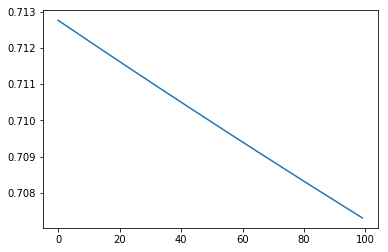

In [28]:
f, ax = plt.subplots()
ax.plot(ls)

# todo: 

[ ] model2: try softmax as activation  
[ ] add batchnorm layer to model1 and model2  
[ ] do exercise 7-1

## 1. Compare activation functions 

In [29]:
# Wrong way to set initial weights 
# because no inplace functions are allowed for Variables with'requires_grad=True'
# Ref: https://discuss.pytorch.org/t/how-to-initiate-parameters-of-layers/1460
def wrong_weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.normal_() # error! 
        m.bias.normal_() # error!
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.data.normal_() 
        m.bias.data.normal_() 
            #alternatively set initial bias to zero
            # m.bias.data.fill_(0)
        

Sigmoid
initial weights: 
error: (tensor(1.0115), tensor(0.9651))
ReLU
initial weights: 
error: (tensor(1.9250), tensor(0.8557))
Softplus
initial weights: 


/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([759])) that is different to the input size (torch.Size([759, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


error: (tensor(1.7451), tensor(0.7730))


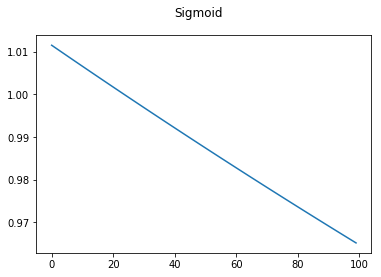

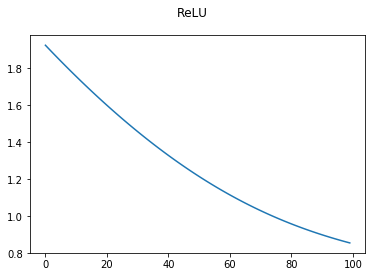

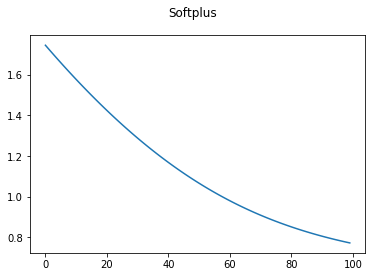

In [30]:
# BCEloss 
criterion = nn.BCELoss(size_average=True)

model_relu = BCModel(X.shape[1], H1, H2, nn.ReLU() )
acts = [nn.Sigmoid(), nn.ReLU(), nn.Softplus()]

for act in acts: 
    actname = act.__class__.__name__
    print(actname)
    model = BCModel(X.shape[1], H1, H2, activation=act)
    model.apply(weight_init)
    print("initial weights: ")
#     model.print_params()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train
    ls = []
    for epoch in range(100):
        #forward
        y_pred = model(X)
        
        #loss
        l = criterion(y_pred, y)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()
        
        #backward pass
        l.backward()
        
        #update parameters
        optimizer.step()
    f,ax = plt.subplots()
    f.suptitle(actname)
    ax.plot(ls)
    print(f"error: {ls[0], ls[-1]}")

Side: setting a random seed for pytorch
- Must set the seed before calling a random number generating function.

In [31]:
torch.manual_seed(2)
print(torch.rand(2))

torch.manual_seed(2)
print(torch.rand(2)) # gives the same random numbers

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


In [32]:
# However, thess will not.

torch.manual_seed(2)
print(torch.rand(2))

print(torch.rand(2))

tensor([ 0.6147,  0.3810])
tensor([ 0.6371,  0.4745])


In [33]:
# Set the seed manually right before calling the random generator 
for i in range(3):
    torch.manual_seed(2)
    print(torch.rand(2))
    

tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])
tensor([ 0.6147,  0.3810])


- Example: nn Linear module's weight initialization from a normal distribution with a random seed

In [34]:
print("original: \n", model.l1.weight.data)
print("normal call: \n", model.l1.weight.data.normal_())
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[-0.5209,  1.0293, -0.3506,  0.1164, -0.1888, -1.4995,  0.1282,
         -0.5361],
        [ 0.0801, -0.1853,  0.7937,  0.9629,  0.7823,  0.4834, -1.8192,
         -0.5442],
        [ 1.9123,  0.2977, -0.7049,  0.4994, -0.0474,  1.3253,  0.9269,
          0.2274]])
normal call: 
 tensor([[-1.3042, -1.1097, -1.2188,  1.1676, -1.0574, -0.1188, -0.3298,
          0.0958],
        [-1.1233, -0.0919, -0.1320, -0.2751, -0.2350,  0.0937, -0.7650,
          1.8299],
        [-0.1752,  0.6990, -0.6861,  0.7202,  0.1963,  0.6142,  1.1566,
          0.4296]])
normal call: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])


In [35]:
print("original: \n", model.l1.weight.data)
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())
torch.manual_seed(RSEED)
print("normal call: \n", model.l1.weight.data.normal_())

original: 
 tensor([[ 0.1665,  0.7911,  0.8560,  0.4094, -1.1371, -1.2034, -1.0190,
          0.3157],
        [-1.4702, -0.2134, -0.8707,  1.6159, -0.2356,  0.9444,  0.5461,
         -1.3575],
        [ 0.1757, -0.1319, -0.2735,  0.3355,  0.1885,  2.1432, -0.2779,
          0.5511]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])
normal call: 
 tensor([[-0.5108,  1.0283, -0.3532,  0.1230, -0.1816, -1.4972,  0.1421,
         -0.5243],
        [ 0.0744, -0.1843,  0.7960,  0.9592,  0.7783,  0.4826, -1.8291,
         -0.5514],
        [ 1.9113,  0.2979, -0.7041,  0.4983, -0.0488,  1.3252,  0.9240,
          0.2255]])


End of side

## 2. Classifying diabetes with minibatch

initial weights: 


/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


error: (tensor(1.4999), tensor(0.4712))


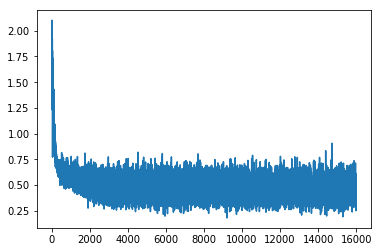

In [36]:
model = BCModel(X.shape[1], H1, H2, activation=act)
model.apply(weight_init)
print("initial weights: ")
# model.print_params()
learning_rate = 0.0005
nEpoch = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
ls = []
for epoch in range(nEpoch):
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Make them tensor
        ## Note this is done by DataLoader
#         x_batch = torch.from_numpy(x_batch).type(torch.float)
#         y_batch = torch.from_numpy(y_batch).type(torch.float)
        #forward
        y_pred = model(x_batch)

        #loss
        l = criterion(y_pred, y_batch)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
f,ax = plt.subplots()
ax.plot(ls)
print(f"error: {ls[0], ls[-1]}")

torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([32, 1])  ==?  32
torch.Size([27, 1])  ==?  32
test error: 0.4733975827693939
test acc:  0.7529880478087649


/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/hjsong/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


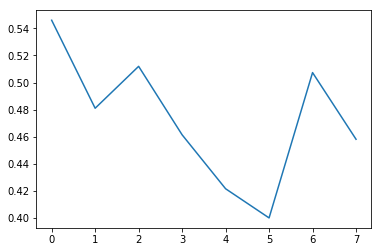

In [39]:
# test loop
testbatch_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):

        ypred_batch = model(xtest_batch)
        print(ypred_batch.size(), " ==? ", test_loader.batch_size)

        testbatch_ls.append(criterion(ypred_batch, ytest_batch).item())

        #make a decision at 0.5
        ypred_batch = (ypred_batch > 0.5).view(ytest_batch.size())
#         pdb.set_trace()
        isCorrect_batch = (ypred_batch == ytest_batch.type(ypred_batch.dtype)).numpy()
        isCorrects.extend(isCorrect_batch)

# Plot error function
f,ax = plt.subplots()
ax.plot(testbatch_ls)
print('test error:', np.mean(testbatch_ls))
test_acc = sum(isCorrects)/len(isCorrects)
print('test acc: ', test_acc)

Let's take a look at misclassified examples.

In [40]:
print(len(isCorrects)) #should be same as number of cycles, ie. len(test_loader)
print(len(test_loader))

251
8


In [41]:
test_acc = sum(isCorrects)/len(isCorrects)
print('test acc: ', test_acc)

test acc:  0.7529880478087649


## 3. Try a deeper network

In [68]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, hidden_activation=nn.ReLU(), output_activation=nn.Sigmoid()):
        """
        dims: a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't includ the output layer's size, which is fixed to 1"""
        super(DeepBCModel,self).__init__()
    
        self.__build_linear_layers__(dims)
        self.n_layers = len(dims)
        
        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_linear_layers__(self, dims):
#         assert(len(self.layers) == 0)
#         for i in range(len(dims)-1):
#             self.add_module(f'h{i}', self.h_activation(nn.Linear(dims[i],dim[i+1])))
#         self.add_module(f'h{len(dim)-1}', self.o_activation(nn.Linear(dims[-1],1)))
                            
        for i in range(len(dims)-1):
            self.add_module(f'li{i}', (nn.Linear(dims[i],dims[i+1])))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
    def forward(self, x):
        y_pred = x
        for mname, m in self.named_children():
            if not isinstance(m, nn.Linear): 
                continue
                
            if (str(self.n_layers-1) in mname):
                act = self.o_activation
            else:
                act = self.h_activation
                
            y_pred = act(m(y_pred))
        return y_pred

def draw_linear_layers(model):
    
           

In [69]:
M = DeepBCModel([8,2,3,4])

In [70]:
for m in M.named_children():
    print(m)

('li0', Linear(in_features=8, out_features=2, bias=True))
('li1', Linear(in_features=2, out_features=3, bias=True))
('li2', Linear(in_features=3, out_features=4, bias=True))
('li3', Linear(in_features=4, out_features=1, bias=True))
('h_activation', ReLU())
('o_activation', Sigmoid())


In [71]:
dataiter = iter(train_loader)
x,y = train_dataset[0];
x = torch.from_numpy(x)
y = torch.tensor([y], dtype=torch.int)

In [72]:
M(x)

tensor([ 0.5251])

In [73]:
# Model
dims = [X.shape[1], 100, 100, 100]
model = DeepBCModel(dims, hidden_activation=nn.ReLU())
model.apply(weight_init)
print("initial weights: ")
for layer in model.children():
    print(layer)

initial weights: 
Linear(in_features=8, out_features=100, bias=True)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=1, bias=True)
ReLU()
Sigmoid()


In [80]:
# model.print_params()
learning_rate = 0.00000003
nEpoch = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
ls = []
for epoch in range(nEpoch):
    for i, (x_batch, y_batch) in enumerate(train_loader):

        #forward
        y_pred = model(x_batch).view(y_batch.size())
#         pdb.set_trace()
        #loss
        l = criterion(y_pred, y_batch)
        ls.append(l)
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
f,ax = plt.subplots()
ax.plot(ls)
print(f"error: {ls[0].item(), ls[-1].item()}")

RuntimeError: Interrupted system call at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/torch/lib/libshm/core.cpp:125

In [ ]:
# test loop
testbatch_ls = []
isCorrects = []
with torch.no_grad():
    for i, (xtest_batch, ytest_batch) in enumerate(test_loader):
        print(ypred_batch.size(), " ==? ", test_loader.batch_size)

        ypred_batch = model(xtest_batch)
        testbatch_ls.append(criterion(ypred_batch, ytest_batch).item())

        #make a decision at 0.5
        ypred_batch = (ypred_batch > 0.5).view(ytest_batch.size())
#         pdb.set_trace()
        isCorrect_batch = (ypred_batch == ytest_batch.type(ypred_batch.dtype)).numpy()
        isCorrects.extend(isCorrect_batch)

# Plot error function
f,ax = plt.subplots()
ax.plot(testbatch_ls)
print('test error:', np.mean(testbatch_ls))
test_acc = sum(isCorrects)/len(isCorrects)
print('test acc: ', test_acc)